# **Milestone 2 - Fingerprint Processing**

This section contains tasks that will help you get familiar with the basics of fingerprint processing.

You may add more code and markdown cells as needed

## TASK 1
* Load the Fingerprint Image `datasets\task3\1.tiff`
* Display it using `plt.imshow()`
* Load the Fingerprint Image `datasets\task3\2.tiff`
* Display it using `plt.imshow()`

#### Load the Fingerprint Image `datasets\task3\1.tiff`

In [2]:
## Hint: use opencv
from classes import Image

im1=Image("datasets/task3/1.tiff")


#### Display the Fingerprint image

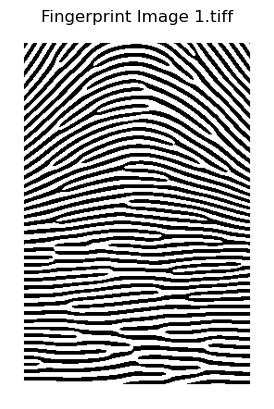

In [3]:
## Hint: use matplotlib
im1.plot("Fingerprint Image "+im1.path.name)


#### Load the Fingerprint Image `datasets\task3\2.tiff`

In [4]:
## Hint: use opencv

im2=Image("datasets/task3/2.tiff")


#### Display the Second Fingerprint image

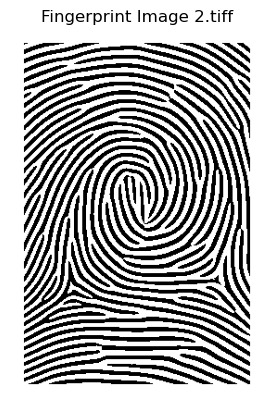

In [5]:
## Hint: use matplotlib
im2.plot("Fingerprint Image "+im2.path.name)


## TASK 2
* Extract the minutia points from the fingerprint images
* Display the minutia vectors

Hint: Each minutiae vector will have the following format: 
> `[x, y, theta, type]` where `type` is `0` for ridge ending and `1` for ridge bifurcation

#### Extract the minutia vectors from the fingerprint images of `TASK 1` as a list of vectors

In [6]:
sc=im1

In [7]:
sc.image=im1.image[:,:,0]

In [8]:
im1.image.shape

(400, 275)

In [2]:
## Hint: use any library you can find from anywhere (but mention the source here in the notebook as a comment)

# checking image shape
sc=im1
sc=Image(im1.image[:,:,0])
# sc.image=im1.image[:,:,0]
# im1.image=im1.image[:,:,0:1]
print(f"{im1.path} Shape: ",sc.image.shape)

# extract minutiae from the image
# minutiae1 = im1.extract_minutiae()

# plot the image with the minutiae
# im1.plot("Fingerprint Image "+im1.path.name,minutiae=minutiae1)



datasets\task3\1.tiff Shape:  (400, 275)


In [4]:
sc.plot("",cmap="gray")

NameError: name 'sc' is not defined

#### Display the minutia vectors

In [3]:
## Hint: Each minutiae vector will have the following format: 
## [x, y, theta, type] where type is 0 for ridge ending and 1 for ridge bifurcation

import cv2
import numpy as np

# Load the fingerprint image
img = sc.image

# Apply a threshold to the image
_, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)

# Define the structuring element for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Perform morphological opening to remove noise
img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# Find contours in the image
contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Define an empty list to store minutiae
minutiae = []

# Loop through the contours
for cnt in contours:
    # Define an empty list to store branch and endpoint minutiae for this contour
    branch_pts = []
    end_pts = []
    
    # Get the convex hull of the contour
    hull = cv2.convexHull(cnt)
    
    # Loop through the hull points
    for i in range(len(hull)):
        # Get the coordinates of the current point
        p1 = hull[i][0]
        
        # Check if the current point is a branch or an endpoint
        if i == 0:
            p2 = hull[-1][0]
            p3 = hull[1][0]
        elif i == len(hull)-1:
            p2 = hull[-2][0]
            p3 = hull[0][0]
        else:
            p2 = hull[i-1][0]
            p3 = hull[i+1][0]
        
        # Calculate the angles between the current point and its neighbors
        angle1 = np.arctan2(p2[1]-p1[1], p2[0]-p1[0])
        angle2 = np.arctan2(p3[1]-p1[1], p3[0]-p1[0])
        angle = np.abs(angle1-angle2)
        
        # If the angle is less than 90 degrees, the current point is a branch
        if angle < np.pi/2:
            branch_pts.append(p1)
        # If the angle is greater than 120 degrees, the current point is an endpoint
        elif angle > 2*np.pi/3:
            end_pts.append(p1)
    
    # Add the branch and endpoint minutiae for this contour to the list of minutiae
    for pt in branch_pts:
        minutiae.append({'type': 'branch', 'x': pt[0], 'y': pt[1]})
    for pt in end_pts:
        minutiae.append({'type': 'endpoint','x': pt[0], 'y': pt[1]})
    
# Display the minutiae
print(minutiae)


NameError: name 'sc' is not defined

## TASK 3
* Display the minutia vectors on the fingerprint images

#### Display the minutia vectors from `TASK 2` on the fingerprint images of `TASK 1`

In [ ]:
## Hint: use matplotlib and stacked images to show the results
## Use red circle for ridge ending and blue square for ridge bifurcation

